<center>
    
 # **ACIT 4610 Mandatory 2**
 
 ## **Multi-Objective VRP: NSGA-II vs SPEA2**
 
 ## **Group nr: 4**

</center>


## **1. Data Ingestion and Setup**

- Import libraries and dependencies
- Load instance(s)
- Build distance matrix and basic helpers


In [20]:
import math, random, time
from typing import List, Tuple, Dict
import time 


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import vrplib
import seaborn as sns


# --- Reproducibility
RNG = random.Random(42)
np.random.seed(42)


In [2]:
def load_instance(path: str):
    inst = vrplib.read_instance(path)
    capacity: int = inst['capacity']
    demands = inst['demand']
    coords = inst["node_coord"]
    depot_ids = inst['depot']

    # Handle coords as dict or ndarray
    if isinstance(coords, dict):
        ordered_ids = list(sorted(coords.keys()))  # e.g., [1,2,...,n]
        coords_arr = np.array([coords[i] for i in ordered_ids], dtype=float)
    else:  # assume it's already an ndarray (shape (n,2))
        coords_arr = np.array(coords, dtype=float)
        ordered_ids = list(range(1, len(coords_arr)+1))

    demand_arr = np.array(demands, dtype=int)

    # depot index in 0-based numpy arrays
    depot_idx = depot_ids[0] - 1  # node_id=1 → index=0

    return capacity, demand_arr, coords_arr, depot_idx, ordered_ids





def distance_matrix(coords_arr: np.ndarray) -> np.ndarray:
    n = coords_arr.shape[0]
    # Efficient vectorized build
    diffs = coords_arr[:, None, :] - coords_arr[None, :, :]
    return np.sqrt((diffs**2).sum(axis=2))
INST_SMALL = "A-n32-k5.vrp"
INST_MED = "B-n78-k10.vrp"
INST_LARGE = "X-n101-k25.vrp"

cap_s, dem_s, XY_s, dep_s, ids_s = load_instance(INST_SMALL)
cap_m, dem_m, XY_m, dep_m, ids_m = load_instance(INST_MED)
cap_l, dem_l, XY_l, dep_l, ids_l = load_instance(INST_LARGE)


D_s = distance_matrix(XY_s)
D_m = distance_matrix(XY_m)
D_l = distance_matrix(XY_l)


## **2. Representation & helpers**

# We use a giant-tour permutation of customers (exclude depot). A split procedure
# constructs feasible routes under capacity.


In [3]:
class VRPInstance:
    def __init__(self, cap, demands, D, depot=0):
        self.cap = cap
        self.demands = demands
        self.D = D # distance matrix
        self.depot = depot

    def customers(self) -> np.ndarray:# return all customer indices (excluding depot)
        n = len(self.demands)
        return np.array([i for i in range(n) if i != self.depot], dtype=int)



def split_routes(tour: np.ndarray, vrp: VRPInstance) -> List[List[int]]: 
   # filling vehicles up to capacity
    routes: List[List[int]] = []
    cur, load = [], 0 
    for node in tour: 
        d = int(vrp.demands[node]) 
        if load + d <= vrp.cap:
            cur.append(node)
            load += d
        else:
            if cur:
                routes.append(cur)
                cur, load = [node], d
            if cur:
                routes.append(cur)
    return routes




def route_distance(route: List[int], vrp: VRPInstance) -> float:
    if not route:
        return 0.0
    dep = vrp.depot
    dist = vrp.D[dep, route[0]]
    for i in range(len(route) - 1):
        dist += vrp.D[route[i], route[i+1]]
    dist += vrp.D[route[-1], dep]
    return float(dist)




def fitness(tour: np.ndarray, vrp: VRPInstance, penalty: float = 1e6) -> Tuple[float, float]:
    routes = split_routes(tour, vrp)

    # Loads in vectorized form
    loads = np.array([vrp.demands[r].sum() for r in routes], dtype=float)

    # Route distances in vectorized form
    dists = []
    D = vrp.D   # distance matrix (precomputed!)
    depot = vrp.depot

    for r in routes:
        if len(r) == 0:
            continue
        idx = np.array(r, dtype=int)
        # depot → first + inside legs + last → depot
        dist = D[depot, idx[0]] + D[idx[-1], depot] + np.sum(D[idx[:-1], idx[1:]])
        dists.append(dist)

    total_dist = float(np.sum(dists))
    load_std = float(loads.std()) if loads.size > 1 else 0.0

    # Penalize capacity violation (vectorized)
    over = np.maximum(0, loads - vrp.cap).sum()
    if over > 0:
        total_dist += penalty * over

    return (total_dist, load_std)





## **3.Genetic operators**



In [4]:
def init_population(vrp: VRPInstance, pop_size: int) -> List[np.ndarray]:
    base = vrp.customers().copy()
    pop = []
    for _ in range(pop_size):
        RNG.shuffle(base)
        pop.append(base.copy())
    return pop


def order_crossover(p1: np.ndarray, p2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    n = len(p1)
    a, b = sorted(RNG.sample(range(n), 2))
    def ox(pa, pb):
        child = np.full(n, -1, dtype=int)
        child[a:b+1] = pa[a:b+1]
        fill = [x for x in pb if x not in child]
        idxs = [i for i in range(n) if child[i] == -1]
        for i, v in zip(idxs, fill):
            child[i] = v
        return child
    return ox(p1, p2), ox(p2, p1)


def swap_mutation(ind: np.ndarray, pm: float = 0.1) -> np.ndarray:
    ind = ind.copy()
    n = len(ind)
    for i in range(n):
        if RNG.random() < pm:
            j = RNG.randrange(n)
            ind[i], ind[j] = ind[j], ind[i]
    return ind

## **4. Non-dominated sorting & utilities**


In [5]:
def dominates(a: Tuple[float, float], b: Tuple[float, float]) -> bool:
    return (a[0] <= b[0] and a[1] <= b[1]) and (a != b)


def fast_nondominated_sort(F):
    F = np.array(F, dtype=float)   # shape (n, m)
    n = len(F)
    S = [set() for _ in range(n)]
    n_dom = np.zeros(n, dtype=int)
    fronts = [[]]

    # ---- Vectorized dominance checks ----
    # For each pair (i,j), check dominates(i,j)
    # dominates(i,j) means: all F[i] <= F[j] and any F[i] < F[j]
    less_equal = (F[:, None, :] <= F[None, :, :])   # shape (n,n,m)
    strictly_less = (F[:, None, :] < F[None, :, :])

    dom_matrix = np.all(less_equal, axis=2) & np.any(strictly_less, axis=2)
    # dom_matrix[i,j] == True if i dominates j

    # Build S and n_dom
    for p in range(n):
        dominated = np.where(dom_matrix[p])[0]
        S[p].update(dominated.tolist())
        n_dom[p] = dom_matrix[:, p].sum()   # how many dominate p
        if n_dom[p] == 0:
            fronts[0].append(p)

    # ---- Front construction ----
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)

    if not fronts[-1]:
        fronts.pop()
    return fronts


def fast_nondominated_sort(F: List[Tuple[float, float]]):
    n = len(F)
    S = [set() for _ in range(n)]
    n_dom = [0]*n
    fronts = [[]]
    for p in range(n):
        for q in range(n):
            if dominates(F[p], F[q]):
                S[p].add(q)
            elif dominates(F[q], F[p]):
                n_dom[p] += 1
        if n_dom[p] == 0:
            fronts[0].append(p)
    i = 0
    while fronts[i]:
        next_front = []
        for p in fronts[i]:
            for q in S[p]:
                n_dom[q] -= 1
                if n_dom[q] == 0:
                    next_front.append(q)
        i += 1
        fronts.append(next_front)
    fronts.pop() # remove last empty
    return fronts


def crowding_distance(front_idx, F):
    if not front_idx:
        return {}

    V = np.array([F[i] for i in front_idx], dtype=float)  # shape (n, m)
    n, m = V.shape
    distances = np.zeros(n)

    for obj in range(m):
        order = np.argsort(V[:, obj])        # sorted indices
        distances[order[0]] = np.inf         # boundary points
        distances[order[-1]] = np.inf

        vals = V[order, obj]
        vmin, vmax = vals[0], vals[-1]
        denom = (vmax - vmin) or 1.0

        # vectorized difference (next - prev)
        if n > 2:
            diff = vals[2:] - vals[:-2]
            distances[order[1:-1]] += diff / denom

    # return mapping back to original indices
    return {idx: dist for idx, dist in zip(front_idx, distances)}



## **5. NSGA-II**



In [6]:
def nsga2(vrp: VRPInstance, pop_size=80, gens=200, pc=0.9, pm=0.1):
    pop = init_population(vrp, pop_size)
    Fvals = [fitness(ind, vrp) for ind in pop]

    for _ in range(gens):
        # Selection
        fronts = fast_nondominated_sort(Fvals)
        ranks = {}
        for r, fr in enumerate(fronts):
            for i in fr:
                ranks[i] = r
        cd_cache = {}
        for fr in fronts:
            cd_cache.update(crowding_distance(fr, Fvals))

        def tournament():
            i, j = RNG.randrange(pop_size), RNG.randrange(pop_size)
            a = (ranks[i], -cd_cache.get(i, 0.0))
            b = (ranks[j], -cd_cache.get(j, 0.0))
            return pop[i] if a < b else pop[j]

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = tournament(), tournament()
            if RNG.random() < pc:   # 🔹 only crossover sometimes
                c1, c2 = order_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            offspring.extend([swap_mutation(c1, pm), swap_mutation(c2, pm)])
        offspring = offspring[:pop_size]

        # Evaluate offspring
        off_F = [fitness(ind, vrp) for ind in offspring]

        # Environmental selection (same as before)
        all_pop = pop + offspring
        all_F = Fvals + off_F
        fronts = fast_nondominated_sort(all_F)
        new_pop, new_F = [], []
        for fr in fronts:
            if len(new_pop) + len(fr) <= pop_size:
                new_pop += [all_pop[i] for i in fr]
                new_F += [all_F[i] for i in fr]
            else:
                cd = crowding_distance(fr, all_F)
                fr_sorted = sorted(fr, key=lambda i: cd[i], reverse=True)
                take = pop_size - len(new_pop)
                sel = fr_sorted[:take]
                new_pop += [all_pop[i] for i in sel]
                new_F += [all_F[i] for i in sel]
                break
        pop, Fvals = new_pop, new_F

    return pop, Fvals


## **6. SPEA2**



In [ ]:
def spea2(vrp: VRPInstance, pop_size=80, archive_size=80, gens=200, pc=0.9, pm=0.1, k_nn=1):
    def assign_spea2_fitness(vals: list, k_nn: int = 1) -> np.ndarray:
        V = np.array(vals, dtype=float)  # shape (n,2) for bi-objective
        n = len(V)

        # ---- Strength values S[i] ----
        # Compare all pairs at once
        dom_matrix = np.all(V[:, None, :] <= V[None, :, :], axis=2) & np.any(V[:, None, :] < V[None, :, :], axis=2)
        # dom_matrix[i,j] = True if i dominates j
        S = dom_matrix.sum(axis=1)

        # ---- Raw fitness R[i] ----
        R = (dom_matrix.T * S).sum(axis=1)

        # ---- Density M[i] ----
        # Pairwise distances
        dists = np.linalg.norm(V[:, None, :] - V[None, :, :], axis=2)
        np.fill_diagonal(dists, np.inf)  # ignore self
        # k-th nearest neighbor distance
        neigh = np.sort(dists, axis=1)
        sigma = neigh[:, k_nn-1] if k_nn <= n-1 else neigh[:, -1]
        M = 1.0 / (sigma + 2.0)

        return R + M


    #  Initialize population
    pop = init_population(vrp, pop_size)
    Fp = [fitness(ind, vrp) for ind in pop]
    archive, Fa = [], []

    for _ in range(gens):
        # Merge pop + archive for fitness assignment
        union = archive + pop
        Fu = Fa + Fp
        fit = assign_spea2_fitness(Fu)

        # Environmental selection -> archive
        idx_sorted = np.argsort(fit)
        new_archive = [union[i] for i in idx_sorted[:archive_size]]
        new_Fa = [Fu[i] for i in idx_sorted[:archive_size]]
        archive, Fa = new_archive, new_Fa

        # Mating selection (binary tournament on fitness)
        def tour_from_archive():
            i, j = RNG.randrange(len(archive)), RNG.randrange(len(archive))
            return archive[i] if sum(Fa[i]) < sum(Fa[j]) else archive[j]

        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = tour_from_archive(), tour_from_archive()
            if RNG.random() < pc:   # 🔹 respect crossover probability
                c1, c2 = order_crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            offspring.extend([swap_mutation(c1, pm), swap_mutation(c2, pm)])
        pop = offspring[:pop_size]
        Fp = [fitness(ind, vrp) for ind in pop]

    return archive, Fa


## **7. Metrics (HV, IGD) & utilities**

In [8]:
def pareto_front(F):
    nd = []
    for i, a in enumerate(F):
        a = tuple(a)  # make sure it's a tuple
        if not any(dominates(tuple(b), a) for j, b in enumerate(F) if j != i):
            nd.append(a)
    return np.array(nd, dtype=float)



def hypervolume(F: np.ndarray, ref: Tuple[float, float]) -> float:
    """2D HV for minimization. Sort by obj1 ascending; sum rectangles to ref."""
    if len(F) == 0:
        return 0.0
    P = F[np.argsort(F[:, 0])]
    hv, prev_f1 = 0.0, P[0, 0]
    prev_f2 = P[0, 1]
    hv += (ref[0] - P[0, 0]) * (ref[1] - P[0, 1])
    for i in range(1, len(P)):
        f1, f2 = P[i]
        hv += (ref[0] - f1) * max(0.0, (prev_f2 - f2))
        prev_f2 = min(prev_f2, f2)
    return max(hv, 0.0)


def igd(F_approx: np.ndarray, F_ref: np.ndarray) -> float:
    if len(F_ref) == 0 or len(F_approx) == 0:
        return float('inf')
    d = []
    for r in F_ref:
        d.append(np.min(np.linalg.norm(F_approx - r, axis=1)))
    return float(np.mean(d))

def run_algorithm(algo, *args, **kwargs):
    start = time.perf_counter()
    result = algo(*args, **kwargs)
    end = time.perf_counter()
    runtime = end - start
    return result, runtime

## **8. Experiment**

In [ ]:
def run_experiment(vrp: VRPInstance, algo: str, seed: int = 0, F_ref=None, **kwargs):
    RNG.seed(seed); np.random.seed(seed)
    t0 = time.time()

    if algo.lower() == "nsga2":
        pop, F = nsga2(vrp, **kwargs)
    elif algo.lower() == "spea2":
        pop, F = spea2(vrp, **kwargs)
    else:
        raise ValueError("algo must be 'nsga2' or 'spea2'")

    dt = time.time() - t0
    F = np.array(F, dtype=float)
    PF = pareto_front(F)

    worst = np.max(F, axis=0)
    ref = tuple(worst * 1.1)
    HV = hypervolume(PF, ref)

    IGD = None
    if F_ref is not None and len(F_ref) > 0:
        IGD = igd(PF, F_ref)

    return {
        "F": F,
        "PF": PF,
        "HV": HV,
        "IGD": IGD,
        "time": dt,
        "ref": ref,
        "pop": pop,    # final population (tours)
        "vrp": vrp     
    }


## **9. Visualization**

In [10]:
def plot_fronts(res_nsga2, res_spea2, title="Pareto fronts (distance vs. load std)"):
    plt.figure(figsize=(6,4))
    plt.scatter(res_nsga2["F"][:,0], res_nsga2["F"][:,1], label="NSGA‑II (all)", alpha=0.35)
    plt.scatter(res_spea2["F"][:,0], res_spea2["F"][:,1], label="SPEA2 (all)", alpha=0.35)
    plt.scatter(res_nsga2["PF"][:,0], res_nsga2["PF"][:,1], label="NSGA‑II PF", marker="x")
    plt.scatter(res_spea2["PF"][:,0], res_spea2["PF"][:,1], label="SPEA2 PF", marker="^")
    plt.xlabel("Total distance (min)")
    plt.ylabel("Route load std (min)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

# i want a plot function that shows the final route in a map drawing lines on paths taken by vehicles
def plot_routes(result: Dict, title="result route plot"):
    # result is the dictionary returned by run_experiment
    vrp = result["vrp"]
    best_tour = result["pop"][0]  # take the first individual in the final population
    routes = split_routes(best_tour, vrp)

    plt.figure(figsize=(10, 6))
    for i, route in enumerate(routes):
        plt.plot(vrp.D[route, 0], vrp.D[route, 1], marker='o', label=f'Route {i+1}')
    plt.scatter(vrp.D[vrp.depot, 0], vrp.D[vrp.depot, 1], c='red', label='Depot', marker='s')
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

## **10. Example usage**

In [11]:
if __name__ == "__main__":
   
    vrp_S = VRPInstance(cap_s, dem_s, D_s, dep_s)
    vrp_M = VRPInstance(cap_m, dem_m, D_m, dep_m)
    vrp_L = VRPInstance(cap_l, dem_l, D_l, dep_l)

    instances = {
        "S": vrp_S,
        "M": vrp_M,
        "L": vrp_L
    }

    algos = ["nsga2", "spea2"]

    #  Three parameter sets as in the assignment brief
    param_sets = [
        {"pop_size": 80, "gens": 600, "pc": 0.8, "pm": 0.15},
        {"pop_size": 120, "gens": 400, "pc": 0.7, "pm": 0.20},
        {"pop_size": 200, "gens": 250, "pc": 0.9, "pm": 0.25}
    ]

    seeds = range(1, 21)  # 20 seeds per experiment

    results = []

    for inst_name, vrp in instances.items():
        for algo in algos:
            for ps_id, params in enumerate(param_sets, 1):
                for seed in seeds:
                    res = run_experiment(
                        vrp,
                        algo,
                        seed=seed,
                        **params
                    )
                    results.append({
                        "instance": inst_name,
                        "algo": algo.upper(),
                        "param_set": ps_id,
                        "seed": seed,
                        "HV": res["HV"],
                        "IGD": res.get("IGD", None),
                        "time": res["time"],
                        "evals": res.get("evals", None)
                    })
                    print(f" Done: {inst_name}-{algo}-P{ps_id}-seed{seed}")

    #  Save all runs to CSV for later plotting
    import pandas as pd
    df = pd.DataFrame(results)
    df.to_csv("results_experiments.csv", index=False)
    print("" \
    "All experiments finished. Results saved to results_experiments.csv")


 Done: S-nsga2-P1-seed1
 Done: S-nsga2-P1-seed2
 Done: S-nsga2-P1-seed3
 Done: S-nsga2-P1-seed4
 Done: S-nsga2-P1-seed5
 Done: S-nsga2-P1-seed6
 Done: S-nsga2-P1-seed7
 Done: S-nsga2-P1-seed8
 Done: S-nsga2-P1-seed9
 Done: S-nsga2-P1-seed10
 Done: S-nsga2-P1-seed11
 Done: S-nsga2-P1-seed12
 Done: S-nsga2-P1-seed13
 Done: S-nsga2-P1-seed14
 Done: S-nsga2-P1-seed15
 Done: S-nsga2-P1-seed16
 Done: S-nsga2-P1-seed17
 Done: S-nsga2-P1-seed18
 Done: S-nsga2-P1-seed19
 Done: S-nsga2-P1-seed20
 Done: S-nsga2-P2-seed1
 Done: S-nsga2-P2-seed2
 Done: S-nsga2-P2-seed3
 Done: S-nsga2-P2-seed4
 Done: S-nsga2-P2-seed5
 Done: S-nsga2-P2-seed6
 Done: S-nsga2-P2-seed7
 Done: S-nsga2-P2-seed8
 Done: S-nsga2-P2-seed9
 Done: S-nsga2-P2-seed10
 Done: S-nsga2-P2-seed11
 Done: S-nsga2-P2-seed12
 Done: S-nsga2-P2-seed13
 Done: S-nsga2-P2-seed14
 Done: S-nsga2-P2-seed15
 Done: S-nsga2-P2-seed16
 Done: S-nsga2-P2-seed17
 Done: S-nsga2-P2-seed18
 Done: S-nsga2-P2-seed19
 Done: S-nsga2-P2-seed20
 Done: S-nsga2-P3-

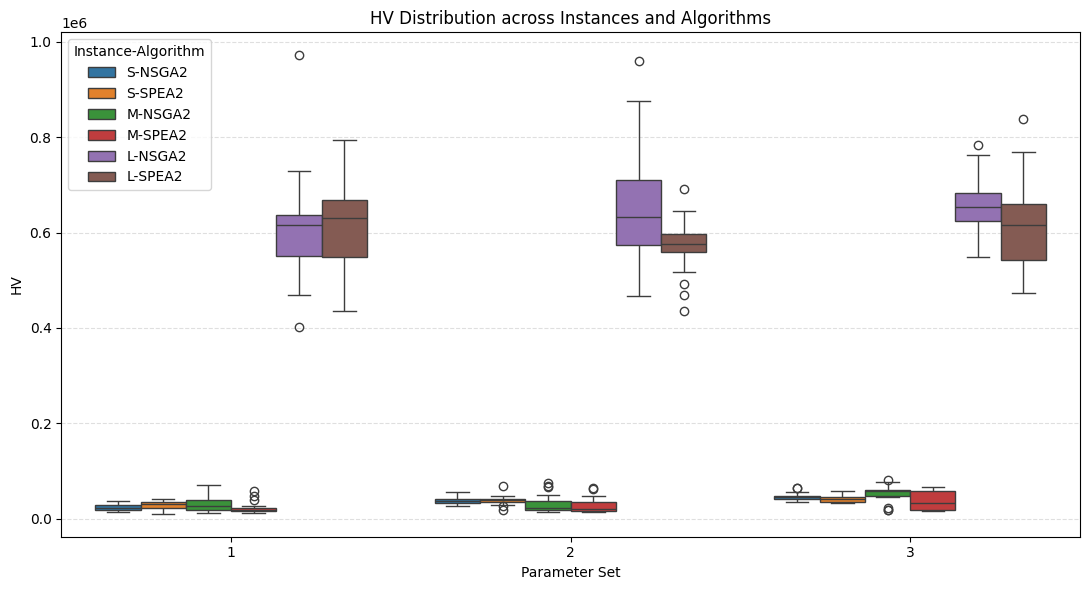

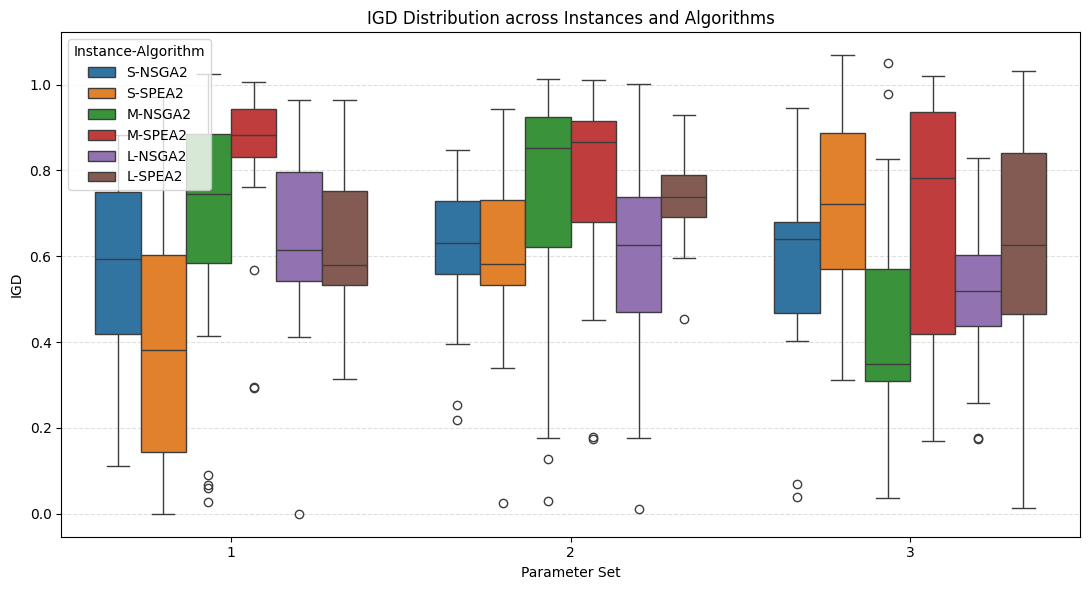

C:\Users\welde\AppData\Local\Temp\ipykernel_20828\2600179912.py:56: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


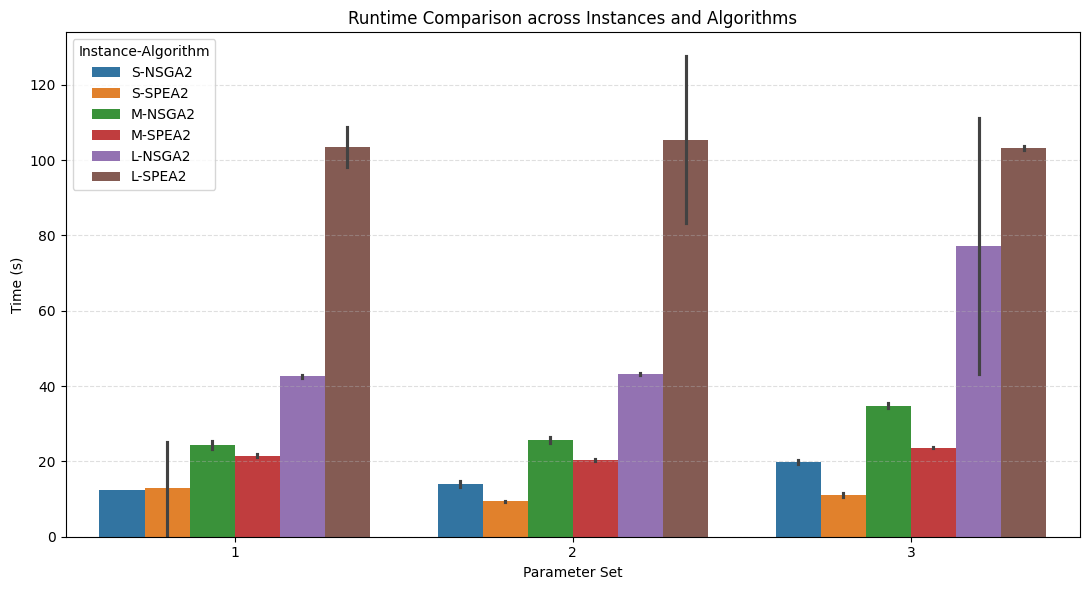

In [ ]:
df = pd.read_csv("results_experiments_filled_with_evals.csv")


def plot_pareto(res_nsga, res_spea, title="Pareto Front Comparison"):
    plt.figure(figsize=(6, 5))
    PF_n = res_nsga["PF"]
    PF_s = res_spea["PF"]

    plt.scatter(PF_n[:, 0], PF_n[:, 1], c="blue", label="NSGA-II", alpha=0.7)
    plt.scatter(PF_s[:, 0], PF_s[:, 1], c="red", label="SPEA2", alpha=0.7)

    plt.xlabel("Total Distance")
    plt.ylabel("Balance Objective")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 2) Combined Boxplots for Metrics
# -----------------------------
def boxplot_metric_all(df, metric):
    plt.figure(figsize=(11, 6))
    df = df.copy()
    df["group"] = df["instance"] + "-" + df["algo"]   # combine labels
    sns.boxplot(
        data=df,
        x="param_set",
        y=metric,
        hue="group"
    )
    plt.title(f"{metric} Distribution across Instances and Algorithms")
    plt.ylabel(metric)
    plt.xlabel("Parameter Set")
    plt.legend(title="Instance-Algorithm")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Combined Runtime Comparison
# -----------------------------
def runtime_plot_all(df):
    plt.figure(figsize=(11, 6))
    df = df.copy()
    df["group"] = df["instance"] + "-" + df["algo"]
    sns.barplot(
        data=df,
        x="param_set",
        y="time",
        hue="group",
        ci="sd"
    )
    plt.title("Runtime Comparison across Instances and Algorithms")
    plt.ylabel("Time (s)")
    plt.xlabel("Parameter Set")
    plt.legend(title="Instance-Algorithm")
    plt.grid(True, axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Example Usage
# -----------------------------
if __name__ == "__main__":
    # Combined plots for all instances & algorithms
    boxplot_metric_all(df, "HV")
    boxplot_metric_all(df, "IGD")
    runtime_plot_all(df)

